# Moist Static Energy Difference Analysis
This notebook evaluates whether the assumption that the difference between the surface and free troposphere MSE, $\epsilon = h - h_{FT}$ varies as the climate warms in the same way for the mean summer day as the temperature percentile $x$ day.

I.e. it evaluates to what extent the assumption of $\delta \epsilon_x = \delta \overline{\epsilon}$ is valid.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os

2023-03-27 15:10:35,730 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
var_keep = ['temp', 'sphum', 'height']      # only keep variables to compute MSE
pressure_ft = 500
use_time_start = 360*2
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
exp_names = exp_names[2:]       # only include kappa > 0.6
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf), drop=True)      # only use times after converged
    ds_use = ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest', drop=True)     # only keep pressure values at surface and FT

     # Only consider summer as has expected circulation
    ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9])       # NH summer is JAS
    ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3])     # SH summer is JFM
    ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
    ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
    ds += [ds_use.load()]

    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
pressure_ft_actual = float(ds[0].pfull[0])        # actual free troposphere pressure in hPa
pressure_surface = float(ds[0].pfull[1])          # surface pressure in hPa

100%|██████████| 6/6 [00:38<00:00,  6.50s/it]


## Get data
Get one dataset, `ds_all[i, j]` `tau_lw[i]` in latitude bin `j`, containing all summer data.

In [3]:
# Get data set averaged over all summer days in extratropics.
# Do this for each optical depth value
lat_min = [0, 40, 70]
lat_max = [20, 65, 90]
n_lat = len(lat_min)
n_pressure = ds[0].pfull.size
quant_plot = np.arange(0, 100, 3)
n_quant = len(quant_plot)

temp_quant = np.zeros((n_exp, n_lat, n_quant, n_pressure))
sphum_quant = np.zeros((n_exp, n_lat, n_quant, n_pressure))
z_quant = np.zeros((n_exp, n_lat, n_quant, n_pressure))

with tqdm(total=n_exp * n_lat * n_quant, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_lat):
            ds_use = ds[i].where((np.abs(ds[i].lat)<=lat_max[j]) & (np.abs(ds[i].lat)>=lat_min[j]), drop=True)

            # Combine hemispheres and average over longitude, time and latitude.
            for k in range(n_quant):
                quant_thresh = ds_use.temp[-1].quantile(quant_plot[k]/100, dim=['lon_lat_time'])
                keep = ds_use.temp[-1] > quant_thresh
                keep = np.expand_dims(keep, 0).repeat(ds_use.temp.shape[0], axis=0)        # repeat keep for both pressure levels
                keep = xr.DataArray(keep, coords=ds_use.coords)                           # Make it a data array
                ds_use2 = ds_use.where(keep, drop=True)
                temp_quant[i, j, k] = ds_use2.temp.mean(dim=['lon_lat_time'])
                sphum_quant[i, j, k] = ds_use2.sphum.mean(dim=['lon_lat_time'])
                z_quant[i, j, k] = ds_use2.height.mean(dim=['lon_lat_time'])
                pbar.update(1)

100%|██████████| 612/612 [01:54<00:00,  5.36it/s]


In [4]:
# MSE and saturated free troposphere MSE
def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1 + w_sat)
    return q_sat

mse_surf = moist_static_energy(temp_quant[:, :, :, -1], sphum_quant[:, :, :, -1], z_quant[:, :, :, -1])
mse_ft_sat = moist_static_energy(temp_quant[:, :, :, 0], sphum_sat(temp_quant[:, :, :, 0], pressure_ft_actual * 100), z_quant[:, :, :, 0])

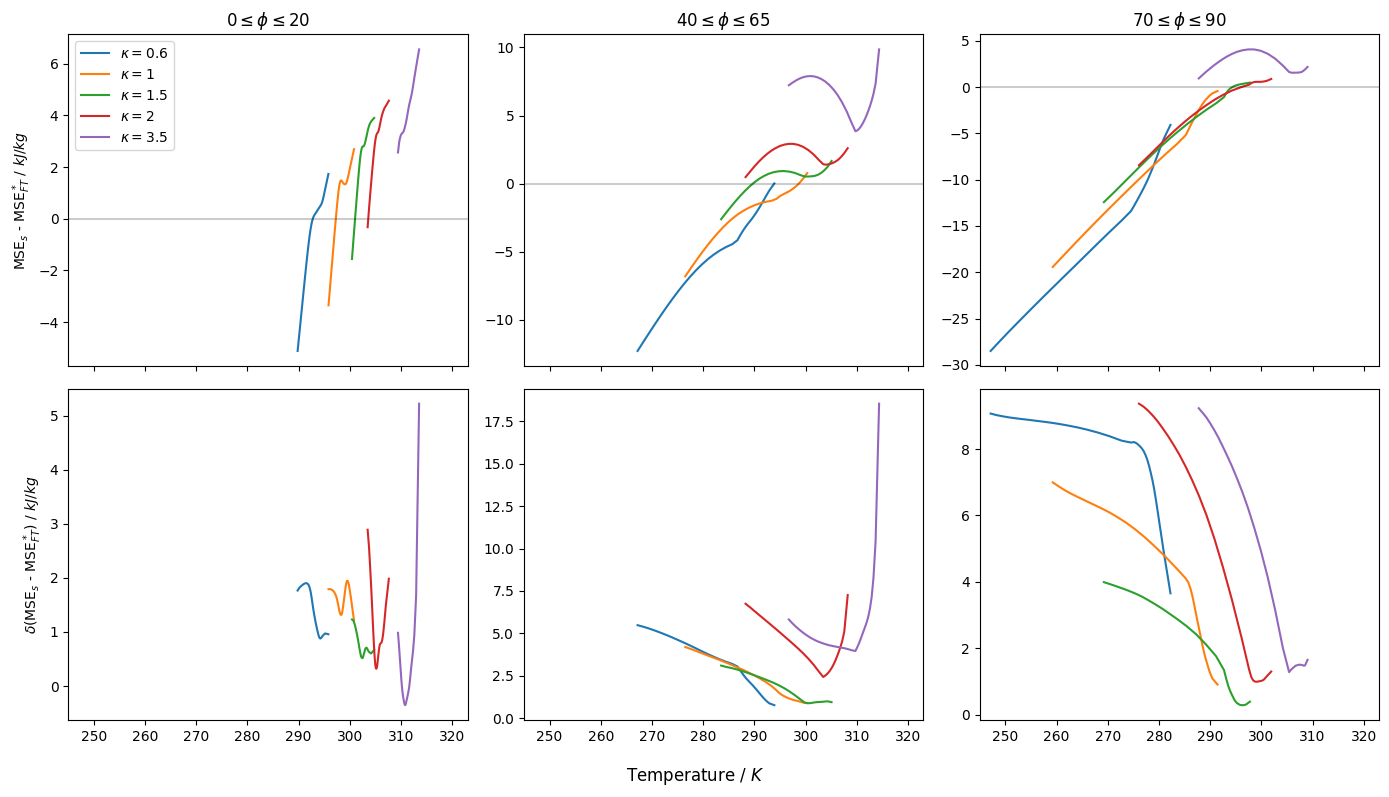

In [5]:
fig, ax = plt.subplots(2,3, figsize=(14, 8), sharex=True)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for j in range(n_lat):
    for i in range(n_exp-1):
        ax[0, j].plot(temp_quant[i, j, :, -1], mse_surf[i, j]-mse_ft_sat[i, j], color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
        ax[1, j].plot(temp_quant[i, j, :, -1], (mse_surf[i+1, j]-mse_ft_sat[i+1, j]) - (mse_surf[i, j]-mse_ft_sat[i, j]),
                      color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax[0, j].hlines(0, 245, 323, color='k', alpha=0.2)
    ax[0, j].set_title(f'${lat_min[j]} \leq \\phi \leq {lat_max[j]}$')
ax[0, 0].legend()
ax[0, 0].set_xlim(245, 323)
ax[0, 0].set_ylabel('MSE$_s$ - MSE$^*_{FT}$ / $kJ/kg$')
ax[1, 0].set_ylabel('$\delta ($MSE$_s$ - MSE$^*_{FT})$ / $kJ/kg$')
fig.supxlabel('Temperature / $K$')
plt.tight_layout();

For the midlatitudes and high latitudes, there seems to be a regime change when the value of $\epsilon = MSE_s - MSE^*_{FT}$ exceeds $0$. For climates ($\kappa$ values) where this value is negative for most temperature percentiles, $x$, then we see a monotonic increase of $\epsilon$ with $x$, with a decreasing gradient as $\epsilon$ approaches 0. But for warmer climates, where $\epsilon > 0$ for most $x$, we see an increase - decrease - increase behaviour.